In [1]:
import pickle
import gym
import time
import numpy as np 
import random
import torch
from run_test import *
%matplotlib inline
import matplotlib.pylab as plt


Logging to /tmp/openai-2018-12-01-07-43-05-268666


set up the code for running trajectories with pong


In [2]:
#try it just for two trajectories

env_id = "BreakoutNoFrameskip-v4"
env_type = "atari"

#env id, env type, num envs, and seed
env = make_vec_env(env_id, 'atari', 1, 0,
                   wrapper_kwargs={
                       'clip_rewards':False,
                       'episode_life':False,
                   })


env = VecFrameStack(env, 4)
agent = PPO2Agent(env, env_type)
#agent = RandomAgent(env.action_space)

/home/dsbrown/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:

def normalize_state(obs):
    obs_highs = env.observation_space.high
    obs_lows = env.observation_space.low
    #print(obs_highs)
    #print(obs_lows)
    #return  2.0 * (obs - obs_lows) / (obs_highs - obs_lows) - 1.0
    return obs / 255.0


In [4]:
checkpoint_min = 100
checkpoint_max = 200
checkpoint_step = 100
checkpoints = []
for i in range(checkpoint_min, checkpoint_max + checkpoint_step, checkpoint_step):
    if i < 1000:
        checkpoints.append('00' + str(i))
    elif i < 10000:
        checkpoints.append('0' + str(i))
print(checkpoints)

['00100', '00200']


In [20]:
demonstrations = []
learning_returns = []
for checkpoint in checkpoints:
    
    model_path = "./models/breakout/checkpoints/" + checkpoint
    
    agent.load(model_path)
    episode_count = 10
    for i in range(episode_count):
        done = False
        traj = []
        r = 0
        
        ob = env.reset()
        #traj.append(ob)
        #print(ob.shape)
        steps = 0
        acc_reward = 0
        while True:
            action = agent.act(ob, r, done)
            ob, r, done, _ = env.step(action)
            #print(ob.shape)
            traj.append(normalize_state(ob))
            steps += 1
            acc_reward += r[0]
            if done:
                print("checkpoint: {}, steps: {}, return: {}".format(checkpoint, steps,acc_reward))
                break
        print("traj length", len(traj))
        print("demo length", len(demonstrations))
        if acc_reward not in learning_returns:
            demonstrations.append(traj)
            learning_returns.append(acc_reward)
    


env.close()


    
    
print(learning_returns)

checkpoint: 00100, steps: 389, return: 6.0
traj length 389
demo length 0
checkpoint: 00100, steps: 382, return: 9.0
traj length 382
demo length 1
checkpoint: 00100, steps: 353, return: 5.0
traj length 353
demo length 2
checkpoint: 00100, steps: 506, return: 9.0
traj length 506
demo length 3
checkpoint: 00100, steps: 132, return: 0.0
traj length 132
demo length 3
checkpoint: 00100, steps: 175, return: 1.0
traj length 175
demo length 4
checkpoint: 00100, steps: 207, return: 2.0
traj length 207
demo length 5
checkpoint: 00100, steps: 127, return: 0.0
traj length 127
demo length 6
checkpoint: 00100, steps: 198, return: 2.0
traj length 198
demo length 6
checkpoint: 00100, steps: 238, return: 2.0
traj length 238
demo length 6
checkpoint: 00200, steps: 498, return: 8.0
traj length 498
demo length 6
checkpoint: 00200, steps: 367, return: 7.0
traj length 367
demo length 7
checkpoint: 00200, steps: 490, return: 9.0
traj length 490
demo length 8
checkpoint: 00200, steps: 703, return: 15.0
traj le

Let's plot the returns to see if they are roughly monotonically increasing.

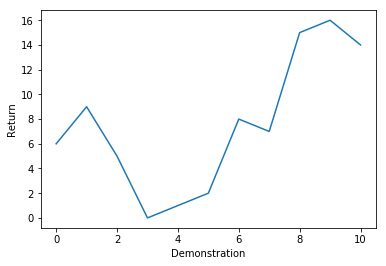

In [21]:
plt.plot(learning_returns)
plt.xlabel("Demonstration")
plt.ylabel("Return")
plt.savefig("breakoutLearningPPO.png")
plt.show()

11
11
[6.0, 9.0, 5.0, 0.0, 1.0, 2.0, 8.0, 7.0, 15.0, 16.0, 14.0]
[6.0, 9.0, 5.0, 0.0, 1.0, 2.0, 8.0, 7.0, 15.0, 16.0, 14.0]


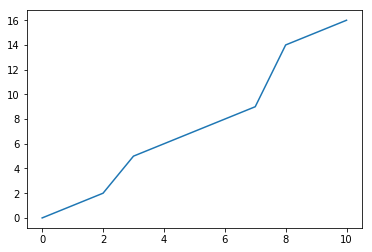

In [22]:
print(len(learning_returns))
print(len(demonstrations))
print([a[0] for a in zip(learning_returns, demonstrations)])
#cheat and sort them to see if it helps learning
sorted_demos = [x for _, x in sorted(zip(learning_returns,demonstrations), key=lambda pair: pair[0])]

sorted_returns = sorted(learning_returns)
print(learning_returns)
plt.plot(sorted_returns)

Split the data into train and validation sets

In [23]:
train_demos = []
train_returns = []
valid_demos = []
valid_returns = []

for i,d in enumerate(sorted_demos):
    print(i)
    if i % 5 is not 4:
        train_demos.append(d)
        train_returns.append(sorted_returns[i])
    else:
        valid_demos.append(d)
        valid_returns.append(sorted_returns[i])

print(train_returns)
print(valid_returns)

0
1
2
3
4
5
6
7
8
9
10
[0.0, 1.0, 2.0, 5.0, 7.0, 8.0, 9.0, 14.0, 16.0]
[6.0, 15.0]


In [4]:
import numpy as np
demoer_returns = [0.0, 1.0, 2.0, 5.0, 7.0, 8.0, 9.0, 14.0, 16.0]
[np.max(demoer_returns), np.min(demoer_returns), np.mean(demoer_returns)]

[16.0, 0.0, 6.888888888888889]

Now I want to build a neural network to predict the reward the learner is trying to optimize. The inputs are 84x84x4 grayscale images. I'm going to try and use the NIPS architecture from DeepMind.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(4, 16, 7, stride=3)
        self.conv2 = nn.Conv2d(16, 16, 5, stride=2)
        self.conv3 = nn.Conv2d(16, 16, 3, stride=1)
        self.conv4 = nn.Conv2d(16, 16, 3, stride=1)
        self.fc1 = nn.Linear(1936, 64)
        self.fc2 = nn.Linear(64, 1)
        
        
    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''
        sum_rewards = 0
        for x in traj:
            x = x.permute(0,3,1,2) #get into NCHW format
            #compute forward pass of reward network
            x = F.leaky_relu(self.conv1(x))
            x = F.leaky_relu(self.conv2(x))
            x = x.view(-1, 1936)
            x = F.leaky_relu(self.fc1(x))
            r = torch.sigmoid(self.fc2(x)) #clip reward?
            sum_rewards += r
        ##    y = self.scalar(torch.ones(1))
        ##    sum_rewards += y
        #print(sum_rewards)
        return sum_rewards
        
            
    
    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        #print([self.cum_return(traj_i), self.cum_return(traj_j)])
        return torch.cat([self.cum_return(traj_i), self.cum_return(traj_j)])
    
class SmallNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(4, 8, 8, stride=4)
        self.conv2 = nn.Conv2d(8, 16, 4, stride=2)
        self.fc1 = nn.Linear(9*9*16, 1)
        #self.fc2 = nn.Linear(256, 1)
        
        
    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''
        sum_rewards = 0
        for x in traj:
            x = x.permute(0,3,1,2)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(-1, 9*9*16)
            r = torch.tanh(self.fc1(x))
            
            sum_rewards += r
        ##    y = self.scalar(torch.ones(1))
        ##    sum_rewards += y
        #print(sum_rewards)
        return sum_rewards
        
            
    
    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        #print([self.cum_return(traj_i), self.cum_return(traj_j)])
        return torch.cat([self.cum_return(traj_i), self.cum_return(traj_j)])
    


Now we train the network. I'm just going to do it one by one for now. Could adapt it for minibatches to get better gradients

In [26]:
def learn_reward(reward_network, optimizer, trajectories, num_iter):
    loss_criterion = nn.CrossEntropyLoss()
    #print(training_data[0])
    cum_loss = 0.0
    for epoch in range(num_iter):
        #pick two random trajectories, traj_i and traj_j and give classification label to later one
        j = np.random.randint(len(trajectories)) 
        i = np.random.randint(len(trajectories))
        while(i == j):
            i = np.random.randint(len(trajectories))
        #print(i,j)
        #traj_i = np.array([[d[0]] for d in trajectories[i]])
        #traj_j = np.array([[d[0]] for d in trajectories[j]])
        traj_i = np.array(trajectories[i])
        traj_j = np.array(trajectories[j])
        if i > j:
            labels = np.array([[0]])
        else:
            labels = np.array([[1]])
            
        traj_i = torch.from_numpy(traj_i).float().to(device)
        traj_j = torch.from_numpy(traj_j).float().to(device)
        labels = torch.from_numpy(labels).to(device)
        
        #zero out gradient
        optimizer.zero_grad()

        #forward + backward + optimize
        outputs = reward_network.forward(traj_i, traj_j).unsqueeze(0)
        #print(outputs)
        #print(labels)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print stats to see if learning
        item_loss = loss.item()
        cum_loss += item_loss
        if epoch % 50 == 49:
            #with torch.no_grad():
            #    print(torch.cat([reward_network.cum_return(torch.from_numpy(np.array(traj)).float()) for traj in trajectories]))
            print(epoch, cum_loss / 50)
            cum_loss = 0.0
    print("finished training")



        
    

Now we create a reward network and optimize it using the training data.

In [4]:
reward = Net()
torch.save(reward.state_dict(), "./random_reward.params")

In [27]:
#doesn't work on my laptop, CUDA out of memory!!!
reward = Net()
reward.to(device)
import torch.optim as optim
optimizer = optim.Adam(reward.parameters(), lr = 0.0001, weight_decay=0.01)
learn_reward(reward, optimizer, train_demos, 1000)

49 3.8246234130859373
99 0.8427362060546875
149 1.8744937133789064
199 1.2678132820129395
249 0.26743599891662595
299 0.2584376621246338
349 0.23490440845489502
399 0.22463390350341797
449 0.2616825294494629
499 0.10480645179748535
549 0.20600961685180663
599 0.19166399002075196
649 0.10051466941833496
699 0.014312171936035156
749 0.024424781799316408
799 0.0733340835571289
849 0.03538543701171875
899 0.015527915954589844
949 0.03111804962158203
999 0.03940750122070313
finished training


Print out learned return for all demos. should be roughly increasing

In [34]:
with torch.no_grad():
    pred_returns = [reward.cum_return(torch.from_numpy(np.array(traj)).float().to(device)).item() for traj in train_demos]
for i, p in enumerate(pred_returns):
    print(i,p,train_returns[i])

0 23.696773529052734 0.0
1 29.600181579589844 1.0
2 36.26249313354492 2.0
3 62.81187438964844 5.0
4 64.08684539794922 7.0
5 65.67391967773438 8.0
6 69.47126007080078 9.0
7 73.68599700927734 14.0
8 80.01277160644531 16.0


In [35]:
with torch.no_grad():
    pred_returns = [reward.cum_return(torch.from_numpy(np.array(traj)).float().to(device)).item() for traj in valid_demos]
for i, p in enumerate(pred_returns):
    print(i,p,valid_returns[i])

0 65.73335266113281 6.0
1 99.59397888183594 15.0


Look at predicted reward over last demo. It's all +1 since demos are monotonically increasing. Maybe need to truncate demos to fixed length?

0
1
2
3
4
5
6
7
8
9
10


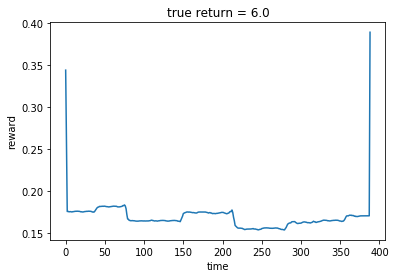

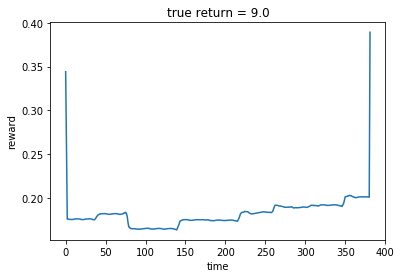

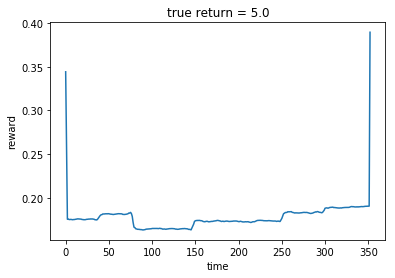

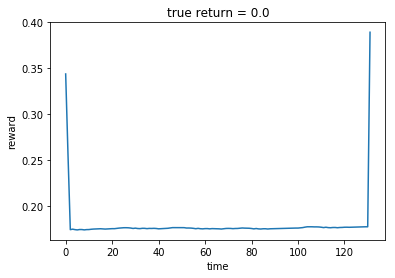

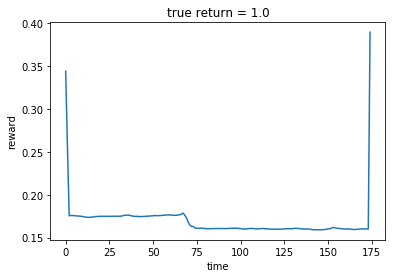

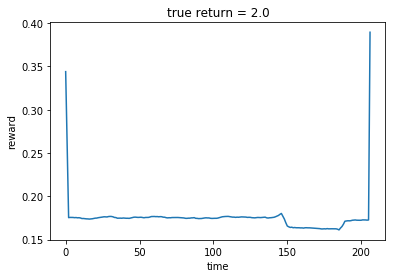

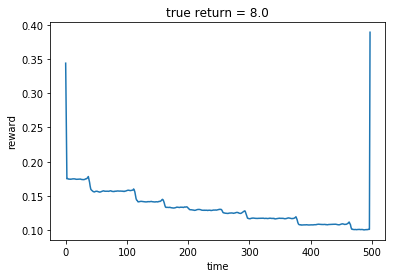

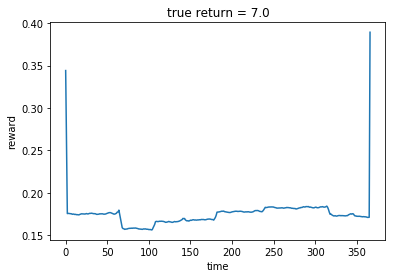

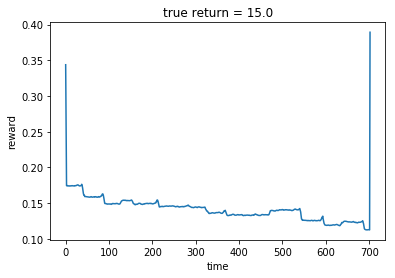

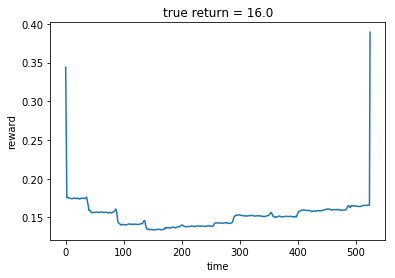

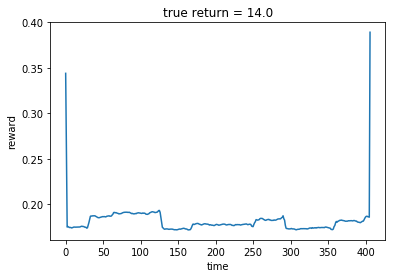

In [29]:

#for last demo

cnt = 0
with torch.no_grad():
    for d in demonstrations:
        rewards = []
        print(cnt)
        for s in d:
            r = reward.cum_return(torch.from_numpy(np.array([s])).float().to(device)).item()
            rewards.append(r)
        plt.figure(cnt)
        plt.plot(rewards)
        plt.xlabel("time")
        plt.ylabel("reward")
        plt.title("true return = {}".format(learning_returns[cnt]))
        cnt += 1
#plt.savefig("learned_mcar_return.png")
plt.show()


Trying shorter snippets of the demos, should use a sliding window over all demos to get lots of training data, but just  trying the last H frames for now, where H is length of first (the shortest) demo 

See what predicted returns look like compared to actual

Check validation accuracy

In [21]:
with torch.no_grad():
    pred_returns = [reward_fh.cum_return(torch.from_numpy(np.array(traj)).float().to(device)).item() for traj in valid_demos]
for i, p in enumerate(pred_returns):
    print(i,p,valid_returns[i])

0 158.86569213867188 6.0
1 508.79510498046875 36.0
2 627.7069702148438 67.0


In [31]:
torch.save(reward.state_dict(), "./breakout_novice_reward_sorted.params")